## Agent

### 1. Set Environment Variables

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

### 2. Set Tools and Model

Tools

In [14]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [23]:
tools = [divide, add, multiply]

Bind Tools Parallel Options
- if parallel_tool_calls=False, model will call tools `sequentially.` = Math Good
- if parallel_tool_calls=True, model will call tools in `parallel` = Generally Good

In [24]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

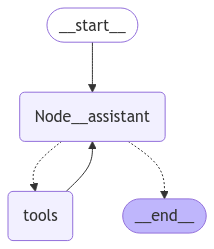

In [27]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Set System Message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Define Node
def Node__assistant(state: MessagesState):
   print("Get State :", state)
   return_state = {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
   print("return_state :", return_state)
   return return_state

# Build Graph
builder = StateGraph(MessagesState)

# Set Node
builder.add_node("Node__assistant", Node__assistant)
builder.add_node("tools", ToolNode(tools)) # Must set name of Node to tools

# Set Edge
builder.add_edge(START, "Node__assistant")
builder.add_conditional_edges("Node__assistant", tools_condition)
builder.add_edge("tools", "Node__assistant")

# Compile Graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### 3. Test

In [28]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = graph.invoke({"messages": messages})

Get State : {'messages': [HumanMessage(content='Add 3 and 4. Multiply the output by 2. Divide the output by 5', additional_kwargs={}, response_metadata={}, id='f4d51085-ca8c-44a6-97a6-ddf6965a50c5')]}
return_state : {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FSjK8aV77gbC7Xv1MKfD3aOf', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 145, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ee1ac9f4-7dcc-4726-bf3f-d0c9f507a536-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_FSjK8aV77gbC7Xv1MKfD3aOf', 

### 3. Bind Tools and Test

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [8]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [9]:
print(f"tool_call.content: {tool_call.content}")
for key, value in tool_call.additional_kwargs['tool_calls'][0].items():
    print(f"{key}: {value}")

tool_call.content: 
id: call_WtlUeIF0Ff3jdaKAHa86MLkR
function: {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
type: function


### 4.MessagesState
- You can just use the MessagesState class from langgraph.graph.message.
- You can add any keys needed beyond messages, which is pre-built 

In [10]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

In [11]:
# initial messages
initial_messages = [
    AIMessage(content="Hello! How can I assist you?"),
    HumanMessage(content="I'm looking for information on marine biology.")
]

# add message
add_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?")

# total messages
from langgraph.graph.message import add_messages
messages = add_messages(initial_messages , add_message)
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you?
================================ Human Message =================================

I'm looking for information on marine biology.
================================== Ai Message ==================================

Sure, I can help with that. What specifically are you interested in?


### 5. Build Graph

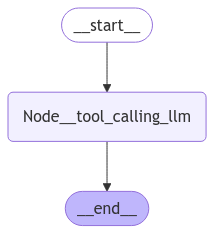

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def Node__tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

# set Node
builder.add_node("Node__tool_calling_llm", Node__tool_calling_llm)

# set Edge
builder.add_edge(START, "Node__tool_calling_llm")
builder.add_edge("Node__tool_calling_llm", END)

# compile graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### 6.Test

Not Call Tool
- if don't call tool
    - AIMessage have content.
    - AIMessage don't have additional_kwargs={'tool_calls'}

In [13]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
messages

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='2d1b9d88-94c3-4c63-b050-550290a0e3d5'),
  AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'stop', 'logprobs': None}, id='run-ba6fb2a3-bde6-4e66-b778-a12915275382-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

Call Tool
- if call tool
    - AIMessage don't have content.
    - AIMessage have additional_kwargs={'tool_calls'}

In [14]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
messages

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='3bc61e02-f88f-47e5-9f7b-85a7883d3112'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q0bDpql6QXEOVADOydV86ebM', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 58, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b5e01947-5a4c-4971-bce3-fb3c1a6a4bf5-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_q0bDpql6QXEOVADOydV86ebM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 1

### 7. Router
- tools_condition is a function that returns True if the latest message (result) from assistant is a tool call, otherwise False.
    - latest message from assistant = `tool call` -> tools_condition routes to `tools`.
    - latest message from assistant = `not tool call` -> tools_condition routes to `END`.

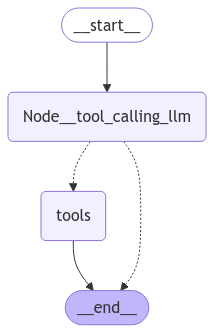

In [15]:
from langgraph.prebuilt import ToolNode

# Tools_condition
from langgraph.prebuilt import tools_condition

# Build graph
builder = StateGraph(MessagesState)

# set Node
builder.add_node("Node__tool_calling_llm", Node__tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))

# set Edge
builder.add_edge(START, "Node__tool_calling_llm")
builder.add_conditional_edges("Node__tool_calling_llm",tools_condition)
builder.add_edge("tools", END)

# compile graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### TestTool Router

In [21]:
from langchain_core.messages import HumanMessage
messages_not_call_tool = [HumanMessage(content="Hello world.")]
messages_not_call_tool = graph.invoke({"messages": messages_not_call_tool})
for m in messages_not_call_tool['messages']:
    m.pretty_print()

print("\n\n")

messages_call_tool = [HumanMessage(content="Multiply 2 and 3")]
messages_call_tool = graph.invoke({"messages": messages_call_tool})
for m in messages_call_tool['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?



================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_e0uMbcdYtmJjRxCJBHHtRJvf)
 Call ID: call_e0uMbcdYtmJjRxCJBHHtRJvf
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
